In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report,ConfusionMatrixDisplay, roc_curve, auc, confusion_matrix

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [27]:
def get_ds(path):
    df = pd.read_csv(path, header = None)
    df = df.drop(0, axis = 1)
    df = df.rename({1: 'game', 2: 'sentiment', 3: 'text'}, axis = 1)
    df = df.dropna()
    df = df[df['sentiment'] != 'Irrelevant']
    df['sentiment'] = df['sentiment'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1})
    return df

In [28]:
df = get_ds('twitter_data.csv')

# DATA PREPARING AND VISUALIZATION

In [29]:
df.head(5)

,game,sentiment,text
0,Borderlands,1,im getting on borderlands and i will murder yo...
1,Borderlands,1,I am coming to the borders and I will kill you...
2,Borderlands,1,im getting on borderlands and i will kill you ...
3,Borderlands,1,im coming on borderlands and i will murder you...
4,Borderlands,1,im getting on borderlands 2 and i will murder ...


<Axes: xlabel='sentiment', ylabel='count'>

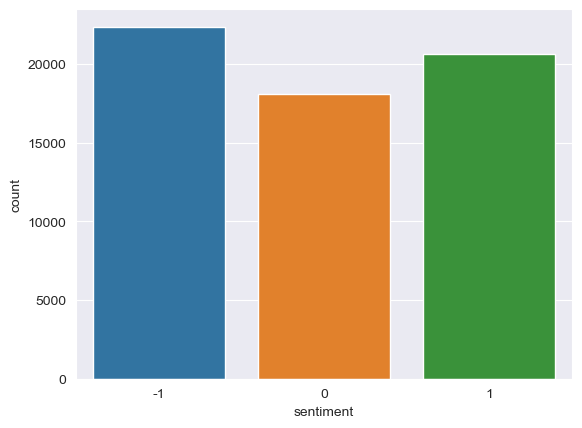

In [30]:
sns.countplot(df, x = 'sentiment')

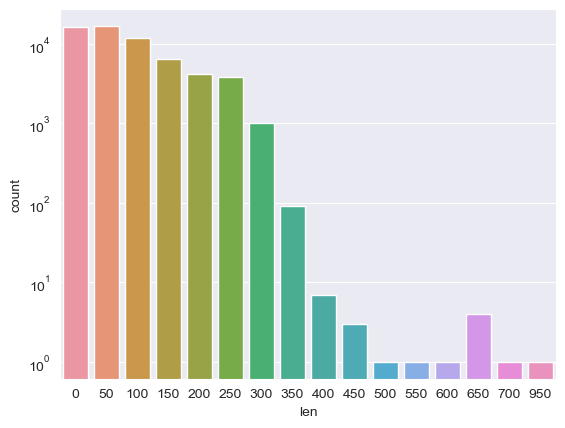

In [31]:
df['len'] = df['text'].apply(lambda x: len(x) // 50)
ax = sns.countplot(df, x = 'len')
plt.yscale('log')
new_labels = [int(label.get_text()) * 50 for label in ax.get_xticklabels()]
ax.set_xticklabels(new_labels)
df.drop('len', axis=1, inplace=True)
plt.show()

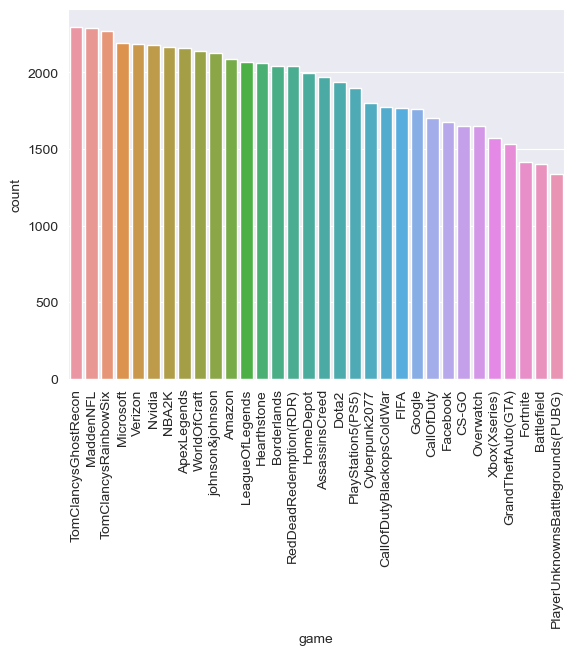

In [32]:
sns.countplot(data=df, x='game', order=df['game'].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

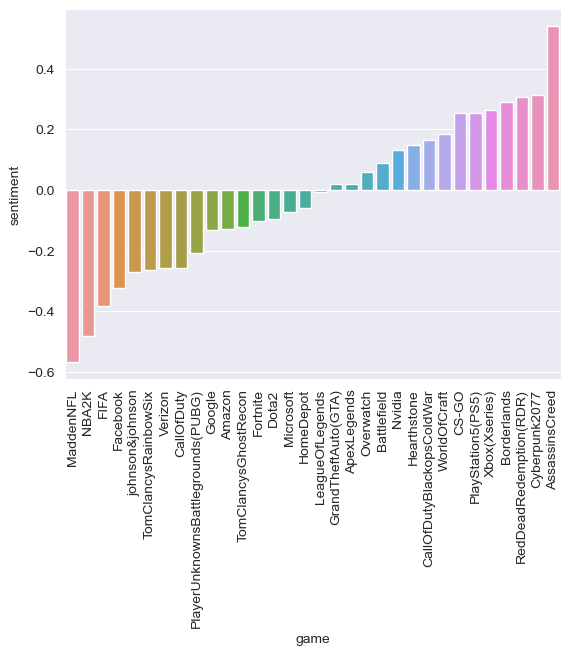

In [33]:
games = (df.groupby('game')['sentiment'].sum() / df.groupby('game')['sentiment'].count()).sort_values()
games = games.reset_index()
sns.barplot(games, x = 'game', y = 'sentiment')
plt.xticks(rotation = 90)
plt.show()

## The graph above shows that the title of the game matters on sentiment.

# TRAIN TEST SPLIT

In [34]:
X, y = df.drop('sentiment', axis = 1), df['sentiment']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

#  DATA PREPROCESSING

In [36]:
class GameTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def concat_sentences(self, text, game):
        return text + ' ' + game
    
    def transform(self, X):
        
        if isinstance(X,str):
            return pd.DataFrame(data = [X], columns=['text'])
       
        if not isinstance(X, pd.DataFrame) or 'text' not in X.columns or X.shape[1] >= 3:
            raise Exception("Wrong X format")
        
        if X.shape[1] == 1:
            return X
        
        X_copy = X.copy()
        X_copy ['text'] =  X_copy .apply(lambda row: self.concat_sentences(row['text'], row['game']), axis=1)
        X_copy  = X_copy.drop('game', axis = 1)
        return X_copy 

In [37]:
class TextCleaningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stopwords = set(stopwords.words('english'))
        
    def fit(self, X, y=None):
        return self
    
    def remove_emojis(self, text):
        if isinstance(text, str):
            emoji_pattern = re.compile("["
                                       u"\U0001F600-\U0001F64F"  # emoticons
                                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                       u"\U00002500-\U00002BEF"  # chinese char
                                       u"\U00002702-\U000027B0"
                                       u"\U00002702-\U000027B0"
                                       u"\U000024C2-\U0001F251"
                                       u"\U0001f926-\U0001f937"
                                       u"\U00010000-\U0010ffff"
                                       u"\u2640-\u2642"
                                       u"\u2600-\u2B55"
                                       u"\u200d"
                                       u"\u23cf"
                                       u"\u23e9"
                                       u"\u231a"
                                       u"\ufe0f"  # dingbats
                                       u"\u3030"
                                       "]+", flags=re.UNICODE)
            return emoji_pattern.sub(r'', text)
        else:
            return text
    
    def transform(self, X):
        X['text'] = X['text'].str.replace('[^\w\s]', '')
        X['text'] = X['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
        X['text'] = X['text'].apply(lambda x: re.sub(r'<.*?>', '', x))
        X['text'] = X['text'].apply(lambda x: re.sub(r'http\S+|www\S+', '', x))
        X['text'] = X['text'].apply(lambda x: re.sub(r'\d+', '', x))
        X['text'] = X['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
        X['text'] = X['text'].apply(lambda x: " ".join(x for x in x.split() if x not in self.stopwords))
        X['text'] = X['text'].apply(self.remove_emojis)
        X['text'] = X['text'].apply(self.lemmatize_sentence)
        return X['text']
    
    def get_wordnet_pos(self, treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        return wordnet.NOUN

    def lemmatize_sentence(self, sentence):
        sentence = sentence.split()
        sentence = nltk.pos_tag(sentence)
        lemma = [] 
        for word, tag in sentence:
            lemma.append(self.lemmatizer.lemmatize(word, pos=self.get_wordnet_pos(tag)))
        return ' '.join(lemma)


In [38]:
class CustomTFIDFVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, min_df=10):
        self.min_df = min_df
       
    def fit(self, X, y=None):
        word_counts = {}
        for row in X:
            for word in row.split():
                word_counts[word] = word_counts.get(word, 0) + 1
        vocabulary = [word for word, count in word_counts.items() if count >=  self.min_df]
        self.tfidf_vectorizer = TfidfVectorizer(vocabulary = vocabulary)
        self.tfidf_vectorizer.fit(X)
        return self
    
    def transform(self, X):
        return self.tfidf_vectorizer.transform(X)

In [39]:
preprocessing_pipeline = Pipeline([
    ('drop_game_column', GameTransformer()),
    ('text_lemmatization', TextCleaningTransformer()),
    ('tfidf_vectorizer', CustomTFIDFVectorizer(5))
])

In [19]:
#X_train = preprocessing_pipeline.fit_transform(X_train)
#X_test = preprocessing_pipeline.transform(X_test)

# MODEL SELECTION

## Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param = {'C': [3,4,5,6,7]}
log_reg = GridSearchCV(LogisticRegression(), param, cv = 5, verbose = 10, scoring= 'balanced_accuracy')

log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START C=3.........................................................
[CV 1/5; 1/5] END ..........................C=3;, score=0.788 total time=   1.2s
[CV 2/5; 1/5] START C=3.........................................................
[CV 2/5; 1/5] END ..........................C=3;, score=0.790 total time=   1.1s
[CV 3/5; 1/5] START C=3.........................................................
[CV 3/5; 1/5] END ..........................C=3;, score=0.793 total time=   1.0s
[CV 4/5; 1/5] START C=3.........................................................
[CV 4/5; 1/5] END ..........................C=3;, score=0.802 total time=   1.1s
[CV 5/5; 1/5] START C=3.........................................................
[CV 5/5; 1/5] END ..........................C=3;, score=0.783 total time=   0.9s
[CV 1/5; 2/5] START C=4.........................................................
[CV 1/5; 2/5] END ..........................C=4;,

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [3, 4, 5, 6, 7]}, scoring='balanced_accuracy',
             verbose=10)

In [23]:
log_reg.best_estimator_

LogisticRegression(C=6)

In [24]:
log_reg.best_score_

0.7994995738962676

### score: 80

## Naive Bayes

In [20]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB

param_grid = {'alpha': [.1, .5, 1, 2, 5]}
bnb = GridSearchCV(BernoulliNB(), param_grid, cv = 10, verbose = 10, scoring = 'balanced_accuracy')
bnb.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START alpha=0.1..................................................
[CV 1/10; 1/5] END ...................alpha=0.1;, score=0.746 total time=   0.0s
[CV 2/10; 1/5] START alpha=0.1..................................................
[CV 2/10; 1/5] END ...................alpha=0.1;, score=0.733 total time=   0.0s
[CV 3/10; 1/5] START alpha=0.1..................................................
[CV 3/10; 1/5] END ...................alpha=0.1;, score=0.735 total time=   0.0s
[CV 4/10; 1/5] START alpha=0.1..................................................
[CV 4/10; 1/5] END ...................alpha=0.1;, score=0.740 total time=   0.0s
[CV 5/10; 1/5] START alpha=0.1..................................................
[CV 5/10; 1/5] END ...................alpha=0.1;, score=0.755 total time=   0.0s
[CV 6/10; 1/5] START alpha=0.1..................................................
[CV 6/10; 1/5] END ...................alpha=0.1;

GridSearchCV(cv=10, estimator=BernoulliNB(),
             param_grid={'alpha': [0.1, 0.5, 1, 2, 5]},
             scoring='balanced_accuracy', verbose=10)

In [21]:
bnb.best_score_

0.7431859255033304

In [22]:
param_grid = {}
gnb = GridSearchCV(GaussianNB(), param_grid, cv = 5, verbose = 10, scoring = 'balanced_accuracy')
gnb.fit(X_train.toarray(), y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................
[CV 1/5; 1/1] END .............................., score=0.639 total time=  20.5s
[CV 2/5; 1/1] START ............................................................
[CV 2/5; 1/1] END .............................., score=0.632 total time=  11.3s
[CV 3/5; 1/1] START ............................................................
[CV 3/5; 1/1] END .............................., score=0.644 total time=  14.1s
[CV 4/5; 1/1] START ............................................................
[CV 4/5; 1/1] END .............................., score=0.648 total time=  13.3s
[CV 5/5; 1/1] START ............................................................
[CV 5/5; 1/1] END .............................., score=0.641 total time=  12.9s


GridSearchCV(cv=5, estimator=GaussianNB(), param_grid={},
             scoring='balanced_accuracy', verbose=10)

In [23]:
gnb.best_score_

0.6410251430832316

In [24]:
param_grid = {'alpha': [.1, .5, 1, 2, 5]}
mnb = GridSearchCV(MultinomialNB(), param_grid, cv = 5, verbose = 10, scoring = 'balanced_accuracy')
mnb.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START alpha=0.1...................................................
[CV 1/5; 1/5] END ....................alpha=0.1;, score=0.756 total time=   0.0s
[CV 2/5; 1/5] START alpha=0.1...................................................
[CV 2/5; 1/5] END ....................alpha=0.1;, score=0.760 total time=   0.0s
[CV 3/5; 1/5] START alpha=0.1...................................................
[CV 3/5; 1/5] END ....................alpha=0.1;, score=0.764 total time=   0.0s
[CV 4/5; 1/5] START alpha=0.1...................................................
[CV 4/5; 1/5] END ....................alpha=0.1;, score=0.765 total time=   0.0s
[CV 5/5; 1/5] START alpha=0.1...................................................
[CV 5/5; 1/5] END ....................alpha=0.1;, score=0.759 total time=   0.0s
[CV 1/5; 2/5] START alpha=0.5...................................................
[CV 1/5; 2/5] END ....................alpha=0.5;,

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1, 2, 5]},
             scoring='balanced_accuracy', verbose=10)

In [25]:
mnb.best_score_

0.7609473045324828

### score: 76

## SVC

## Linear

In [18]:
from sklearn.svm import SVC

In [26]:
from sklearn.svm import SVC

lin_svc = SVC(kernel = 'linear')
lin_svc = GridSearchCV(lin_svc, {}, cv = 5, verbose = 10, scoring = 'balanced_accuracy')
lin_svc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................
[CV 1/5; 1/1] END .............................., score=0.785 total time= 2.6min
[CV 2/5; 1/1] START ............................................................
[CV 2/5; 1/1] END .............................., score=0.793 total time= 2.5min
[CV 3/5; 1/1] START ............................................................
[CV 3/5; 1/1] END .............................., score=0.791 total time= 2.6min
[CV 4/5; 1/1] START ............................................................
[CV 4/5; 1/1] END .............................., score=0.796 total time= 2.6min
[CV 5/5; 1/1] START ............................................................
[CV 5/5; 1/1] END .............................., score=0.788 total time= 2.6min


GridSearchCV(cv=5, estimator=SVC(kernel='linear'), param_grid={},
             scoring='balanced_accuracy', verbose=10)

In [27]:
lin_svc.best_score_

0.7908023835242523

### score: 80

## Poly

In [ ]:
poly_svc = SVC(kernel = 'poly')
poly_svc = GridSearchCV(poly_svc, {}, cv = 5, verbose = 10, scoring = 'balanced_accuracy')
poly_svc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................
[CV 1/5; 1/1] END .............................., score=0.947 total time= 8.8min
[CV 2/5; 1/1] START ............................................................
[CV 2/5; 1/1] END .............................., score=0.949 total time= 9.2min
[CV 3/5; 1/1] START ............................................................
[CV 3/5; 1/1] END .............................., score=0.949 total time= 8.6min
[CV 4/5; 1/1] START ............................................................
[CV 4/5; 1/1] END .............................., score=0.951 total time= 9.1min
[CV 5/5; 1/1] START ............................................................


In [ ]:
poly_svc.best_score_

### score: 95

# rbf

In [22]:
rbf_svc = SVC(kernel = 'rbf')
rbf_svc = GridSearchCV(rbf_svc, {}, cv = 5, verbose = 10, scoring = 'balanced_accuracy')
rbf_svc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................
[CV 1/5; 1/1] END .............................., score=0.910 total time= 6.6min
[CV 2/5; 1/1] START ............................................................
[CV 2/5; 1/1] END .............................., score=0.914 total time= 6.5min
[CV 3/5; 1/1] START ............................................................
[CV 3/5; 1/1] END .............................., score=0.916 total time= 6.6min
[CV 4/5; 1/1] START ............................................................
[CV 4/5; 1/1] END .............................., score=0.918 total time= 6.5min
[CV 5/5; 1/1] START ............................................................
[CV 5/5; 1/1] END .............................., score=0.916 total time= 6.4min


GridSearchCV(cv=5, estimator=SVC(), param_grid={}, scoring='balanced_accuracy',
             verbose=10)

In [23]:
rbf_svc.best_score_

0.9146573852541063

### score: 91.5

# sigmoid

In [24]:
sigmoid_svc = SVC(kernel = 'sigmoid')
sigmoid_svc = GridSearchCV(sigmoid_svc, {}, cv = 5, verbose = 10, scoring = 'balanced_accuracy')
sigmoid_svc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................
[CV 1/5; 1/1] END .............................., score=0.692 total time= 1.8min
[CV 2/5; 1/1] START ............................................................
[CV 2/5; 1/1] END .............................., score=0.699 total time= 1.9min
[CV 3/5; 1/1] START ............................................................
[CV 3/5; 1/1] END .............................., score=0.700 total time= 2.6min
[CV 4/5; 1/1] START ............................................................
[CV 4/5; 1/1] END .............................., score=0.699 total time= 2.2min
[CV 5/5; 1/1] START ............................................................
[CV 5/5; 1/1] END .............................., score=0.696 total time= 2.4min


GridSearchCV(cv=5, estimator=SVC(kernel='sigmoid'), param_grid={},
             scoring='balanced_accuracy', verbose=10)

In [25]:
sigmoid_svc.best_score_

0.6970623913201419

### Score: 70

## Tree Clasifier

In [20]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier()
tree_model = GridSearchCV(tree_model, {}, cv = 5, verbose = 10, scoring = 'balanced_accuracy')
tree_model.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................
[CV 1/5; 1/1] END .............................., score=0.829 total time=   6.9s
[CV 2/5; 1/1] START ............................................................
[CV 2/5; 1/1] END .............................., score=0.820 total time=   6.4s
[CV 3/5; 1/1] START ............................................................
[CV 3/5; 1/1] END .............................., score=0.824 total time=   6.8s
[CV 4/5; 1/1] START ............................................................
[CV 4/5; 1/1] END .............................., score=0.830 total time=   7.1s
[CV 5/5; 1/1] START ............................................................
[CV 5/5; 1/1] END .............................., score=0.824 total time=   6.4s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), param_grid={},
             scoring='balanced_accuracy', verbose=10)

In [21]:
tree_model.best_score_

0.8252523073861294

### score 82.5

## Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'max_depth': [3,6,9, None]}

rf_model = RandomForestClassifier()
rf_model = GridSearchCV(rf_model, param_grid, cv = 5, verbose = 10, scoring = 'balanced_accuracy')
rf_model.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START max_depth=3.................................................
[CV 1/5; 1/4] END ..................max_depth=3;, score=0.383 total time=   0.6s
[CV 2/5; 1/4] START max_depth=3.................................................
[CV 2/5; 1/4] END ..................max_depth=3;, score=0.394 total time=   0.7s
[CV 3/5; 1/4] START max_depth=3.................................................
[CV 3/5; 1/4] END ..................max_depth=3;, score=0.375 total time=   0.6s
[CV 4/5; 1/4] START max_depth=3.................................................
[CV 4/5; 1/4] END ..................max_depth=3;, score=0.391 total time=   0.6s
[CV 5/5; 1/4] START max_depth=3.................................................
[CV 5/5; 1/4] END ..................max_depth=3;, score=0.403 total time=   0.6s
[CV 1/5; 2/4] START max_depth=6.................................................
[CV 1/5; 2/4] END ..................max_depth=6;,

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 6, 9, None]},
             scoring='balanced_accuracy', verbose=10)

In [ ]:
rf_model.best_score_

### score 92%

## Final model which I will use is SVC with polynomial kernel


# MODEL TRAINING

In [40]:
class ScoringPipeline(Pipeline):
    
    def __init__(self, steps):
        super().__init__(steps)
        self.is_fit = False 
    
    def fit(self, X, y=None, **fit_params):
        self.is_fit = True
        return super().fit(X, y, **fit_params)
    
    def predict(self, X, **predict_params):
        if not self.is_fit:
            self.fit(X)
        return super().predict(X, **predict_params)
    
    def plot_multiclass_roc(self,X_test, y_test, n_classes, figsize=(17, 6)):
        y_score = super().decision_function(X_test)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        fig, ax = plt.subplots(figsize=figsize)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver operating characteristic example')
        for i in range(n_classes):
            ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i-1))
        ax.legend(loc="best")
        ax.grid(alpha=.4)
        sns.despine()
        plt.show()
    
    def score(self, X, y):
        
        y_pred = self.predict(X)
        print(classification_report(y, y_pred))
        self.plot_multiclass_roc(X, y, n_classes = len(set(y_pred)))
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [-1,0,1])
        disp.plot()

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

full_pipeline = ScoringPipeline(steps = [
    ('preprocessing_pipeline', preprocessing_pipeline),
    ('poly_svc_model', SVC(kernel = 'poly'))
])

In [42]:
full_pipeline.fit(X_train, y_train)

ScoringPipeline(steps=[('preprocessing_pipeline',
                        Pipeline(steps=[('drop_game_column', GameTransformer()),
                                        ('text_lemmatization',
                                         TextCleaningTransformer()),
                                        ('tfidf_vectorizer',
                                         CustomTFIDFVectorizer(min_df=5))])),
                       ('poly_svc_model', SVC(kernel='poly'))])

# MODEL EVALUATING

              precision    recall  f1-score   support

          -1       0.95      0.96      0.96      4472
           0       0.94      0.95      0.94      3622
           1       0.96      0.94      0.95      4131

    accuracy                           0.95     12225
   macro avg       0.95      0.95      0.95     12225
weighted avg       0.95      0.95      0.95     12225



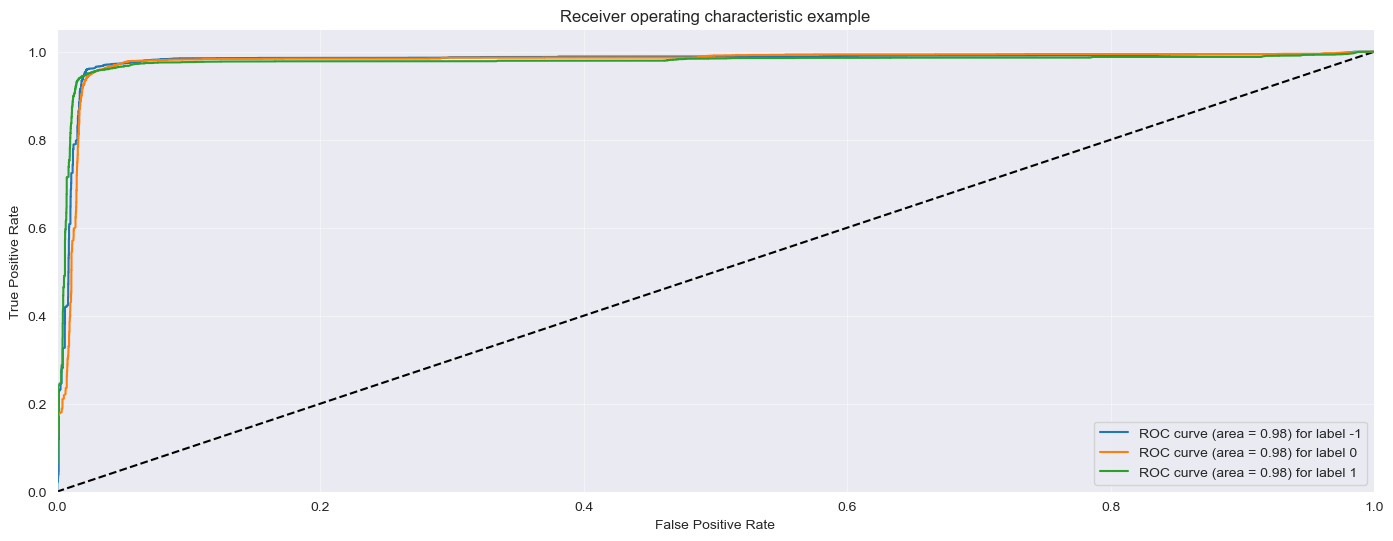

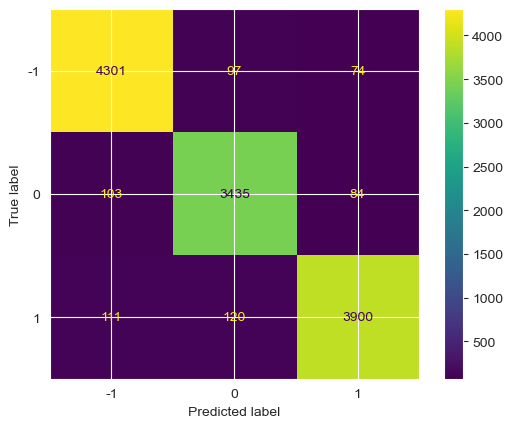

In [43]:
full_pipeline.score(X_test,y_test)

In [44]:
full_pipeline.predict('What an awful game. I hate it.')

array([-1], dtype=int64)

## Check how important is game column for our model.

In [21]:
X_test = X_test.drop('game', axis = 1)

In [22]:
X_test.head(5)

,text
24798,United Onslaught is on! Get Divine Evolvable R...
32983,"The Benjamin Cup scoring system is so good, th..."
32885,to have pics of Fortnite all their way back vi...
43790,I will not support you in the next election if
47573,"Target gives pay bonus of $2 per hour, offers ..."


              precision    recall  f1-score   support

          -1       0.90      0.97      0.93      4472
           0       0.96      0.91      0.93      3622
           1       0.95      0.93      0.94      4131

    accuracy                           0.94     12225
   macro avg       0.94      0.93      0.94     12225
weighted avg       0.94      0.94      0.94     12225



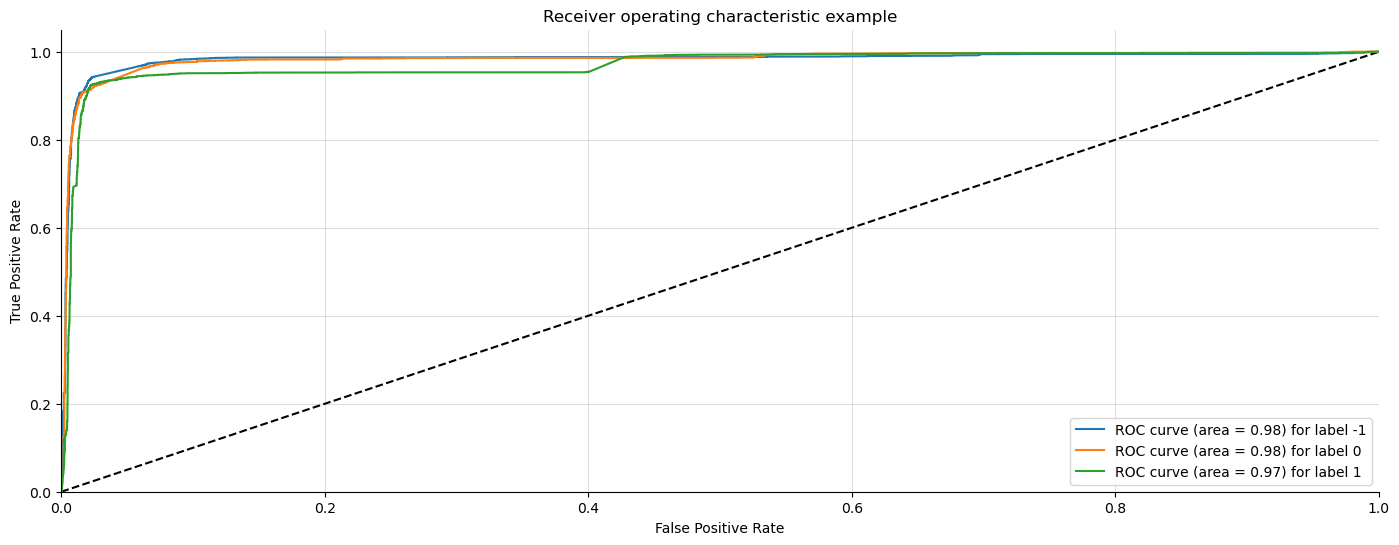

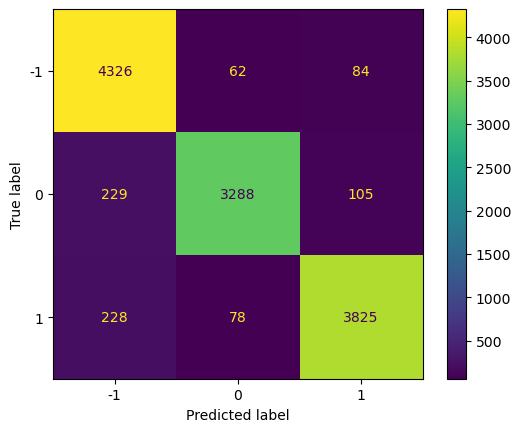

In [23]:
full_pipeline.score(X_test,y_test)

In [45]:
import joblib

joblib_file = "full_pipeline_model.pkl"
joblib.dump(full_pipeline, joblib_file)

['full_pipeline_model.pkl']